...Continued from Part 1

In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import datetime
from datetime import timedelta
import statsmodels.api as sm
from pandas import concat
from tqdm import tqdm
from prettytable import PrettyTable
import warnings
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.layers import GRU
import tensorflow as tf
from tensorflow.keras import metrics
from statsmodels.tsa.arima.model import ARIMA
import math
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

warnings.filterwarnings('ignore')
warnings.warn("deprecated", DeprecationWarning)
pd.set_option('display.max_columns', None)

In [ ]:
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'casestudy')
drive.mount(MOUNTPOINT)
dirPath = os.getcwd()
print(dirPath)

Mounted at /content/gdrive
/content


In [ ]:
# Load data
df = pd.read_excel(dirPath+'/gdrive/My Drive/casestudy/dfseries.xlsx')

In [ ]:
df

,start_time,total,run_time,pass,no_run,fail,exec_count
0,2016-01-04,964,6.098808,919,2,43,42
1,2016-01-05,1441,5.716791,219,449,773,82
2,2016-01-06,4257,15.538374,1977,1961,319,94
3,2016-01-07,4148,33.325904,3665,11,472,128
4,2016-01-08,1002,7.131022,941,50,11,46
...,...,...,...,...,...,...,...
754,2018-01-27,2074,10.934531,367,52,1655,77
755,2018-01-28,6363,14.067379,474,2404,3485,122
756,2018-01-29,6706,17.891077,825,2473,3408,150
757,2018-01-30,4569,17.840890,775,1605,2189,95


In [ ]:
df.index = df.start_time
df.head(3)

,start_time,total,run_time,pass,no_run,fail,exec_count
start_time,,,,,,,
2016-01-04,2016-01-04,964,6.098808,919,2,43,42
2016-01-05,2016-01-05,1441,5.716791,219,449,773,82
2016-01-06,2016-01-06,4257,15.538374,1977,1961,319,94


### Univariate Forecasting

We will first attempt to use only the 'start_time' Feature to forecast the runtime - in a time-window of one day. We will use this information, to train models to forecast the 'run_time' in a future timeframe.

In [ ]:
dfseries = pd.DataFrame(index=df.index)
dfseries['run_time'] = df['run_time']


In [ ]:
dfseries.head()

,run_time
start_time,
2016-01-04,6.098808
2016-01-05,5.716791
2016-01-06,15.538374
2016-01-07,33.325904
2016-01-08,7.131022


###Removing Anomalies

While it is not a good idea to delete all the outliers that we saw in the EDA section - as they may have some info on the test execution and the resultant trends in the runtime wave - It is good to remove, amomalies among those outliers. These could be due to issues beyond the framework of test execution itself. These are few in number, but could impact the forecasting adversely.

With domain knowledge and analysing the historical time series, we set a cut off of 100 hours runtime.

In [ ]:
dfseries[dfseries['run_time']>100].sort_values(by='run_time')

,run_time
start_time,
2016-10-23,107.673083
2016-07-11,123.575239
2016-10-25,126.022491
2016-07-14,127.016142
2016-11-13,132.949890
2016-10-30,138.309762
2016-10-31,152.685266
2016-07-06,172.422867
2017-12-26,177.996796


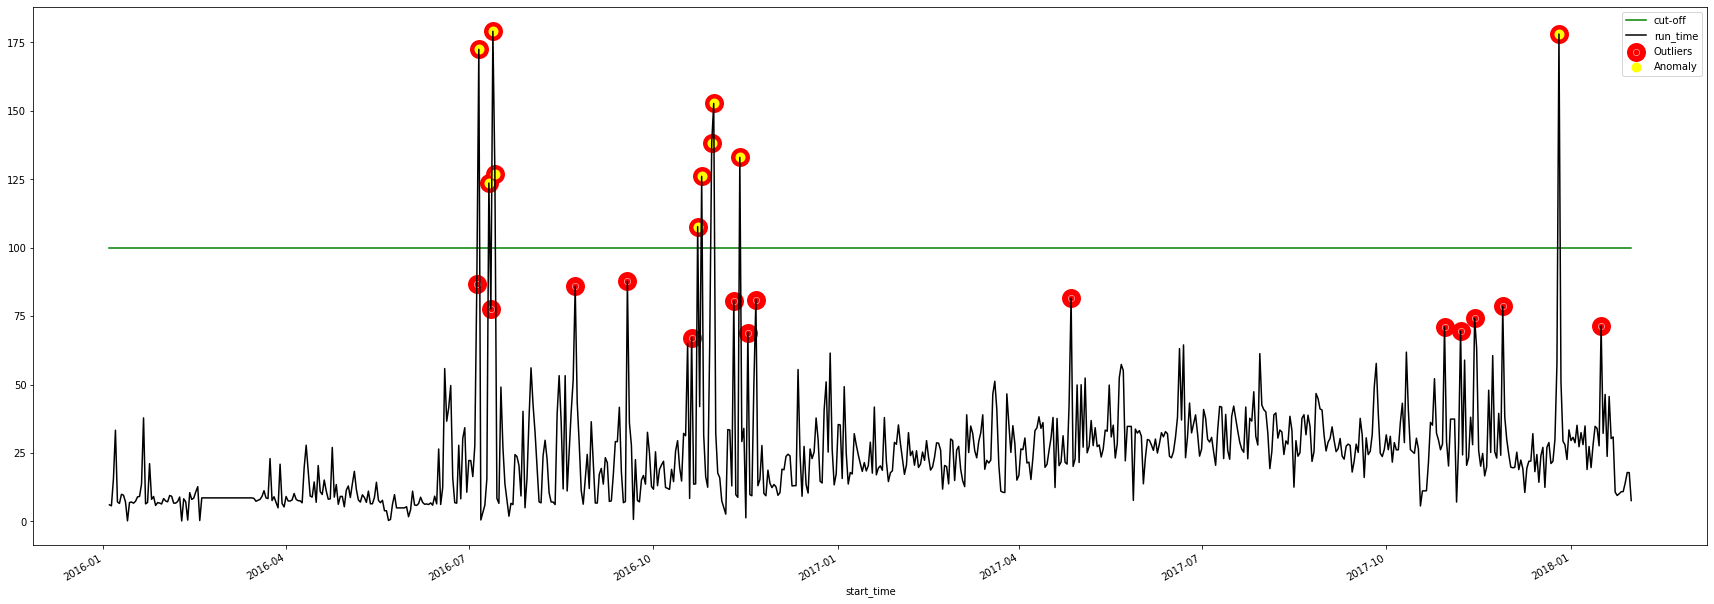

In [ ]:
y = list()
y += len(dfseries) * [100]
plt.plot(dfseries.index,y,'g-',label = 'cut-off')
dfseries['run_time'].plot(figsize=(30,11),color='black')
plt.scatter(x= dfseries[dfseries['run_time']>65].index, y= dfseries[dfseries['run_time']>65]['run_time'],color='red', label = 'Outliers',linewidths=13)
plt.scatter(x= dfseries[dfseries['run_time']>100].index, y= dfseries[dfseries['run_time']>100]['run_time'],color='yellow', label = 'Anomaly',linewidths=4)
plt.legend()
plt.show()

It is clear that there is only one anomaly in the later part of the time series. The execution results had stabilized after end of 2016. We will remove these 10 anomalies for now.

In [ ]:
dfseries.drop(index = dfseries[dfseries['run_time']>100].index, axis=0, inplace=True)

In [ ]:
len(dfseries)

749

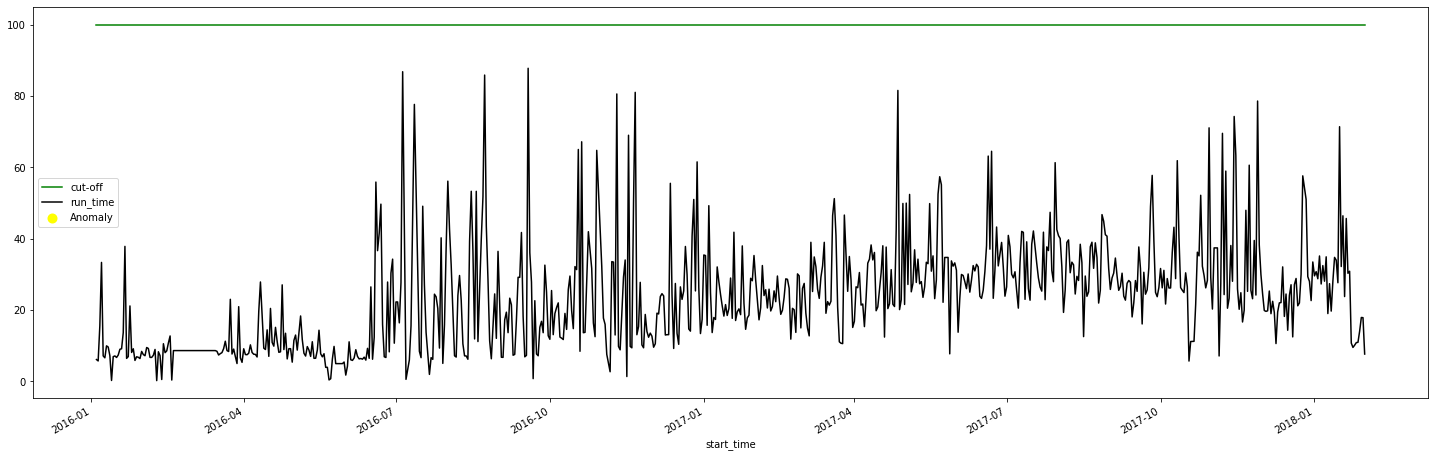

In [ ]:
y = list()
y += len(dfseries) * [100]
plt.plot(dfseries.index,y,'g-',label = 'cut-off')
dfseries['run_time'].plot(figsize=(25,8),color='black')
plt.scatter(x= dfseries[dfseries['run_time']>100].index, y= dfseries[dfseries['run_time']>100]['run_time'],color='yellow', label = 'Anomaly',linewidths=4)
plt.legend()
plt.show()

Anomalies have been successfully removed.

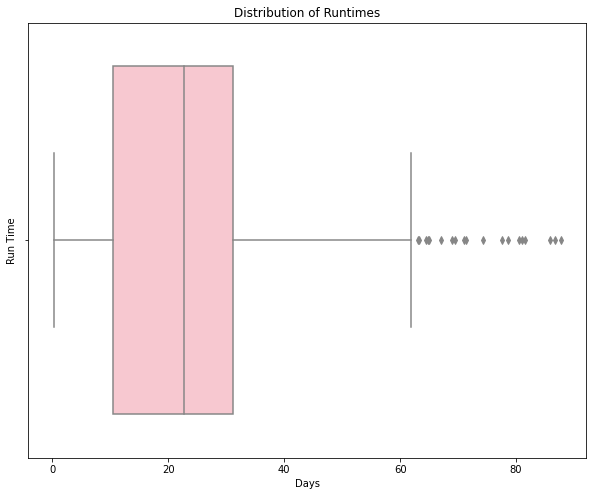

In [ ]:
plt.subplots(figsize=(10,8))
sns.boxplot(dfseries['run_time'],color='pink')
plt.title('Distribution of Runtimes')
plt.xlabel('Days')
plt.ylabel('Run Time')
plt.show()

We are not left with outliers, that we would still use for our forecast modelling for reasons discussed above. The mean runtime is still around 24 hours.

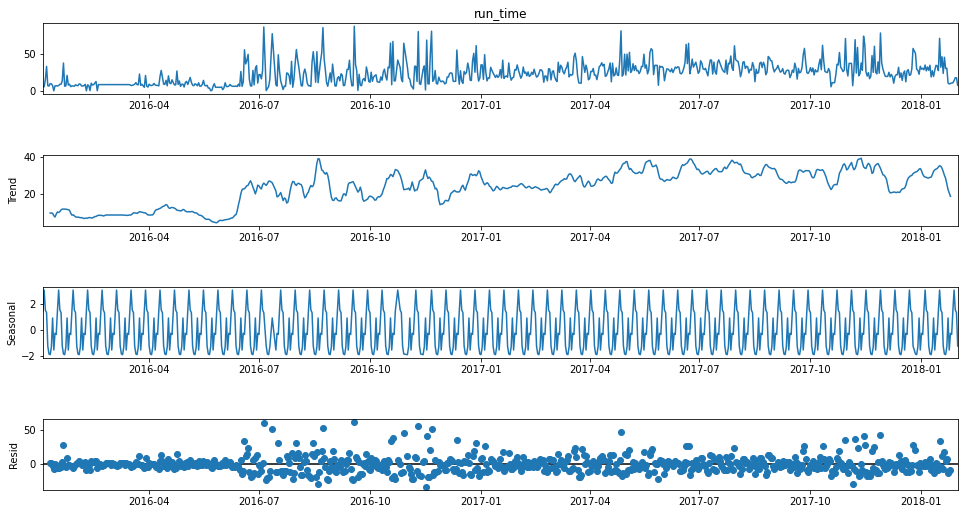

In [ ]:
decomposition = sm.tsa.seasonal_decompose(dfseries.run_time, period=12)
fig = decomposition.plot()
fig.set_size_inches(15, 8)
plt.show()

Now the trend is not influenced by the anomalies. We see a more or less stationary trend from June-2016

###Choice of metrics

Primarily this is a Regression problem. We choose Root Mean Square error, to evaluvate the average difference between the predictions and observed values. This metric is intutive and interpretable easily. It also penalizes large errors.

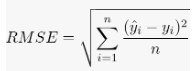

Hence RMSE will be our primary metric to evaluvate and compare the model performances.

The ideal value of RMSE is zero. The farther it deviates from zero, the less accurate the model is - with no upper limit in the positive scale.

In [ ]:
def find_rmse(actual, predictions):
  return np.round(np.sqrt(((actual-predictions)**2).mean()),3)

###Modelling

We will first attempt a few classical ML models with the univariate - 'run_time' feature and see the performance.

In [ ]:
# Define Utility Functions

def visualize_results(modelName, test_y, y_pred):
  fig,ax = plt.subplots(figsize=(20,8))
  plt.plot(test_y,color='green')
  plt.plot(y_pred,color='red')
  plt.xlabel('Date')
  plt.ylabel('Runtime')
  plt.title(modelName+': Actual vs. Predicted Runtime')
  plt.legend(['Actual', 'Predicted'])
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(labelbottom=False)   
  plt.show()

def time_window(timeSeries, timeSteps):
  '''
  Featurizes time series into previous timeSteps 
  '''
  X = []
  y = []
  for i in range(len(timeSeries)):
    if i+timeSteps > len(timeSeries):
      break
    X.append(timeSeries[i:i+timeSteps])
    y.append(timeSeries[i+timeSteps])
  X = np.array(X)
  y = np.array(y)
  return X,y

## Featurization

The approach we will take here is to engineer features is as follows:

The runtime at any timestep 't' will be the independent variable. 

The dependent variables will be:
1. Runtimes at n previous steps.
2. Moving Averages from the previous 'n' time steps.

Here 'n' is a time window hyper parameter - that we would have to tune.

In [ ]:
modelName = ''
modelScore = {}

## Base Line Model

We know that the ideal and lowest value of RMSE is zero. We would like to fix a worst case scenario for the performance of the model using a random baseline model.

We will use the common techinque of Naive forecasting using persistance for the same.

Basically to preserve the timeseries along with randomness, for a given timestep, the model will output the previous value.

In [ ]:
modelName = 'Baseline'

In [ ]:
current_t = pd.DataFrame(dfseries.values)
previous_t = current_t.shift(1) # Shift index forward by 1.
dftest = concat([previous_t, current_t ],axis=1)
dftest.columns = ['Prev','Current']
dftest.head(10)

,Prev,Current
0,NaN,6.098808
1,6.098808,5.716791
2,5.716791,15.538374
3,15.538374,33.325904
4,33.325904,7.131022
5,7.131022,6.590522
6,6.590522,9.946398
7,9.946398,9.607321
8,9.607321,7.182080
9,7.182080,0.239850


In [ ]:
# train test split
size = int(len(dftest) * 0.75)

train = dftest.values[1:size] # Ignore first NAN value.
train_X = train[:,0]
train_y = train[:,1]

test = dftest.values[size:]
test_X = test[:,0]
test_y = test[:,1]

In [ ]:
print(dfseries[size:].index.min())
print(dfseries[size:].index.max())

2017-07-27 00:00:00
2018-01-31 00:00:00


Being a time series data, we have done a time split taking the latest part of the time series as test data to evaluate the model. We would be using the last six months of data for validation.

In [ ]:
#Model predicts the previous value in the time-series.
def baseline_model(test_X):
  y_pred = []
  for i in test_X:
    y_pred.append(i)      
  return y_pred

In [ ]:
y_pred = baseline_model(test_X)  
score = find_rmse(test_y,y_pred)
print("RMSE score:",score)

RMSE score: 15.31


The worst case RMSE Score is seen above. The ideal RMSE Score is 0.0. 
We are to now see which model improves the score from baseline rmse score, is the best model.

Let us now visualize the results  of the baseline model.

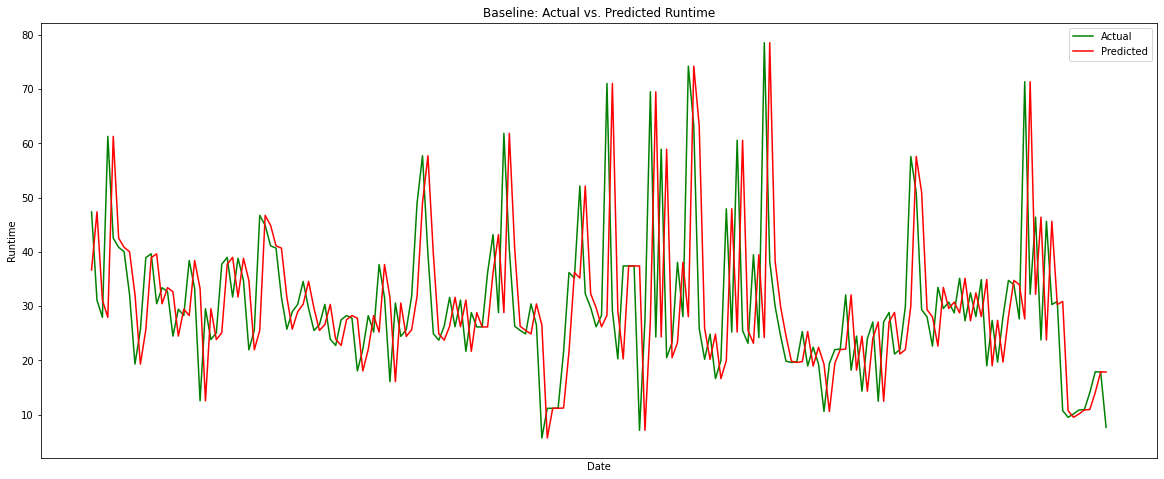

In [ ]:
visualize_results(modelName, test_y, y_pred)

As we can see since this is a naive forecasting persistance model, the predicted value lags by the current value at 't' by 1.

In [ ]:
modelScore[modelName] = score

## Exponential Moving Averages

In [ ]:
modelName = 'Exponential Moving Averages'

We will use Exponential Moving Averages as a feature. Where the previous value gets the maxiumum weightage and the weights for older values decreases exponentially. 
This gives form to the the theory that the recent values have a higher bearing on the value to be predicted, than the older ones.

P′t=α∗Pt−1+(1−α)∗P′t−1



In [ ]:
# train test split
size = int(len(dfseries) * 0.75)
train = dfseries['run_time'].values[0:size]
test = dfseries['run_time'].values[size:]

In [ ]:
def find_ema(test_X,alpha):
  y_pred = list()
  y_p = test_X[0]
  for i in range(0,len(test_X)):
    y_pred.append(y_p)
    y_p = int((alpha)*(test_X[i]) + ((1-alpha)*y_p))
  return y_pred

In [ ]:
alpha = 0.2 # tuned best value.
y_pred = find_ema(test,alpha)

In [ ]:
score = find_rmse(test_y,y_pred)
print("RMSE score:",score)

RMSE score: 12.834


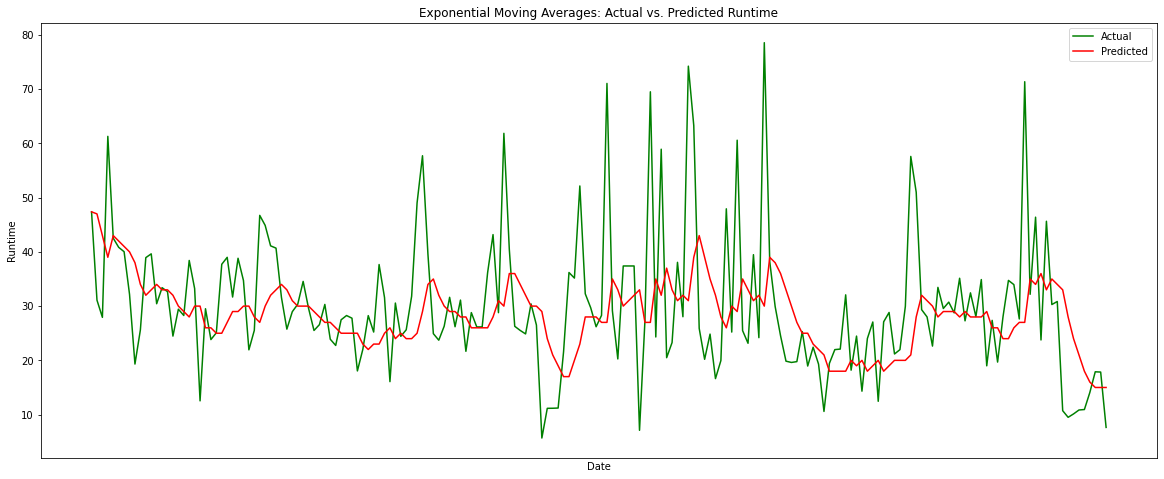

In [ ]:
visualize_results(modelName, test_y, y_pred)
modelScore[modelName] = score

The exponential weighted average is giving a higher result than the simple persistance baseline model we had used. The RMSE has improved.

We will calculate the Exponentially Moving Averages for all datapoints in our dataset - for use as a feature during modelling, if needed.

In [ ]:
ema = find_ema(dfseries.values.reshape(-1,1),alpha)

Let us visualize the entire dataset - Actual defects count and predicted defect counts using EMA method.

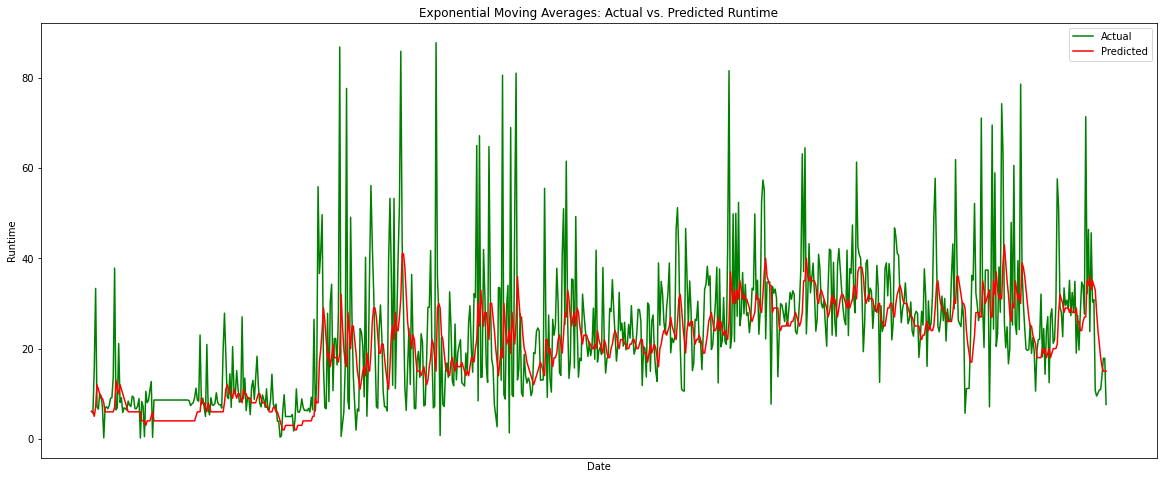

In [ ]:
visualize_results(modelName, dfseries.values.reshape(-1,1), ema)

The overall trend is successfully predicted. We would need to see if the individual predictions get better in the forthcoming models

In [ ]:
def ema_feature(X,timeSteps):
  '''
  Add EMA value at timestep 't'
  '''
  lst = []
  for i in range(len(X)):
    lst.append(np.append(X[i],ema[i+timeSteps]))
  X_ema = np.array(lst)
  return X_ema  

#### Train Test Split

In [ ]:
# Train Test Split
size = int(len(dfseries) * 0.75)
timesteps = 5 # Tuned value. Use past five days runtimes to predict one step in the future.
train = dfseries['run_time'].values[0:size]
X_train, y_train = time_window(train, timesteps)
test = dfseries['run_time'].values[size:]
X_test, y_test = time_window(test, timesteps)

Let us attempt training classic ML models:
1. Linear Regression
2. Decision Trees
3. Random Forests
4. GBDT

### Linear Regression

In [ ]:
modelName = 'Linear Regression'
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = []
y_pred = model.predict(X_test)

RMSE score: 12.602


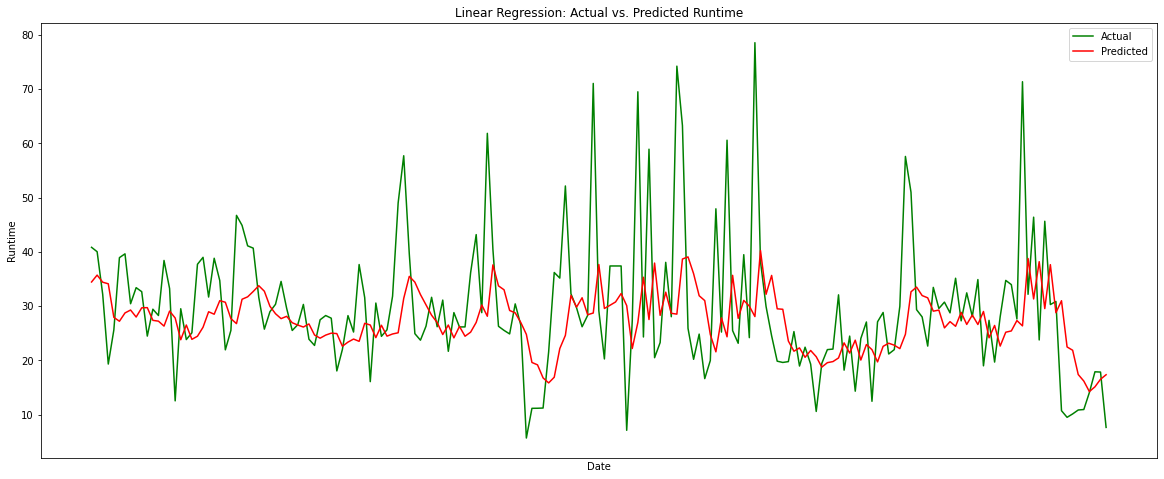

In [ ]:
score = find_rmse(y_test,y_pred)
print("RMSE score:",score)
visualize_results(modelName, y_test, y_pred)
modelScore[modelName] = score

### Decision Tree

In [ ]:
# Hyper Parameter/s Tuning
regressor = DecisionTreeRegressor(random_state = 101)
parameters = {'max_depth':[1, 5, 10, 50, None], 'min_samples_split':[2, 5, 10, 100, 500], 'min_samples_leaf':[1, 5, 10, 100, 500]}
grid_cv = GridSearchCV(regressor, parameters, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestmax_depthdt = grid_cv.best_params_['max_depth']
bestmin_samples_leafdt = grid_cv.best_params_['min_samples_leaf']
bestmin_samples_splitdt = grid_cv.best_params_['min_samples_split']

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 100}


In [ ]:
modelName = 'Decision Tree'
model = DecisionTreeRegressor(max_depth= bestmax_depthdt, min_samples_leaf= bestmin_samples_leafdt, min_samples_split= bestmin_samples_splitdt, random_state = 101)
model.fit(X_train, y_train)
y_pred = []
y_pred = model.predict(X_test)

RMSE score: 12.569


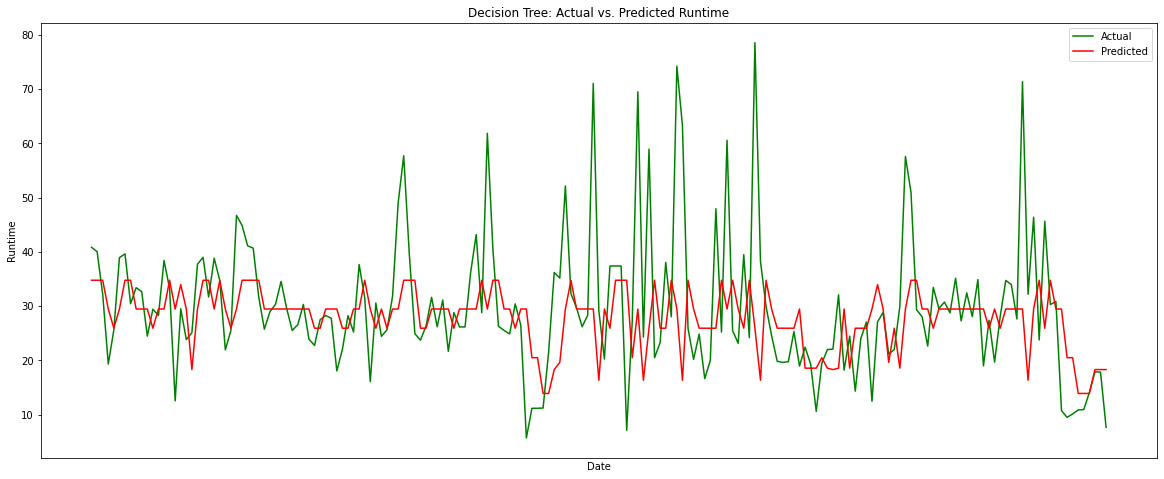

In [ ]:
score = find_rmse(y_test,y_pred)
print("RMSE score:",score)
visualize_results(modelName, y_test, y_pred)
modelScore[modelName] = score

### Random Forest

In [ ]:
# Tune Hyper parameters
regressor = RandomForestRegressor(random_state=101)
parameters = {'n_estimators':[5,10,50 ,100],'max_depth':[1, 5, 10, 50, None], 'min_samples_split':[2, 5, 10, 100, 500], 'min_samples_leaf':[1, 5, 10, 100, 500]}
grid_cv = GridSearchCV(regressor, parameters, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestmin_samples_splitrf = grid_cv.best_params_['min_samples_split']
bestn_estimatorsrf = grid_cv.best_params_['n_estimators']
bestmax_depthrf = grid_cv.best_params_['max_depth']
bestmin_samples_leafrf = grid_cv.best_params_['min_samples_leaf']

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
modelName = 'Random Forest'
modelrf = RandomForestRegressor(n_estimators = bestn_estimatorsrf, min_samples_split = bestmin_samples_splitrf ,max_depth  = bestmax_depthrf, min_samples_leaf  =bestmin_samples_leafrf , random_state=101)
modelrf.fit(X_train, y_train)
y_pred = []
y_pred = modelrf.predict(X_test)

RMSE score: 12.165


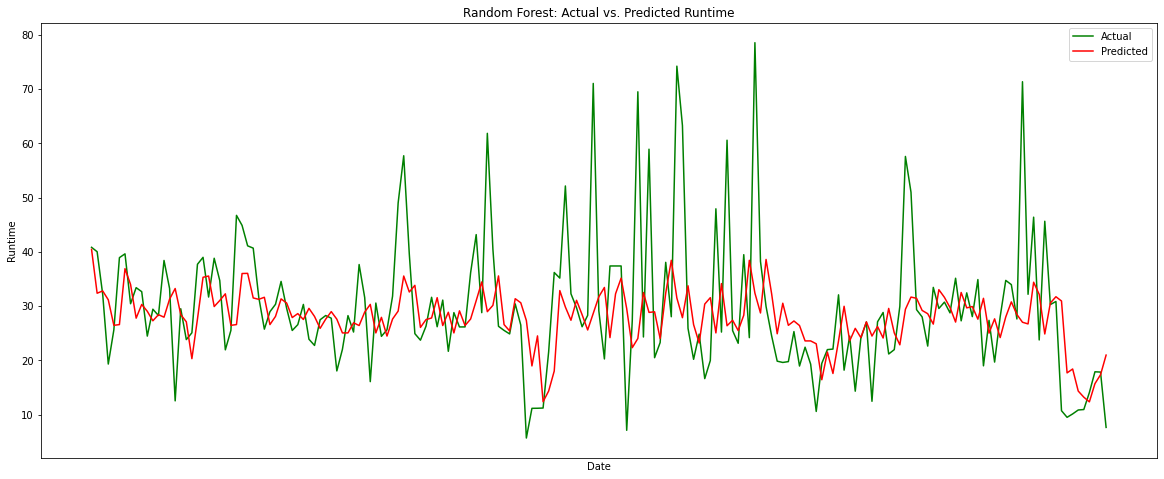

In [ ]:
score = find_rmse(y_test,y_pred)
print("RMSE score:",score)
visualize_results(modelName, y_test, y_pred)
modelScore[modelName] = score

In [ ]:
# save the model to disk
filename = dirPath+"/gdrive/My Drive/casestudy/model_save/rfuni.sav"
pickle.dump(modelrf, open(filename, 'wb'))

### GBDT

In [ ]:
# Hyper Parameter/s Tuning
regressor = XGBRegressor(random_state = 101, objective='reg:squarederror')
parameters = {'learning_rate':[0.1, 0.3, 0.5], 'n_estimators':[5,10,50 ,100],'max_depth':[1, 5, None], 'min_samples_split':[2, 5, 10, 100, 500]}
grid_cv = GridSearchCV(regressor, parameters, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True, verbose=10, n_jobs=-1)
grid_cv.fit(X_train,y_train)
print('Best Parameters: ', grid_cv.best_params_)
bestlearning_rategb = grid_cv.best_params_['learning_rate']
bestn_estimatorsgb = grid_cv.best_params_['n_estimators']
bestmax_depthgb = grid_cv.best_params_['max_depth']

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Parameters:  {'learning_rate': 0.5, 'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [ ]:
modelName = 'GBDT'
model = XGBRegressor(learning_rate= bestlearning_rategb, n_estimators = bestn_estimatorsgb, max_depth= bestmax_depthgb,  random_state = 101, objective='reg:squarederror')
model.fit(X_train, y_train)
y_pred = []
y_pred = model.predict(X_test)

RMSE score: 12.184


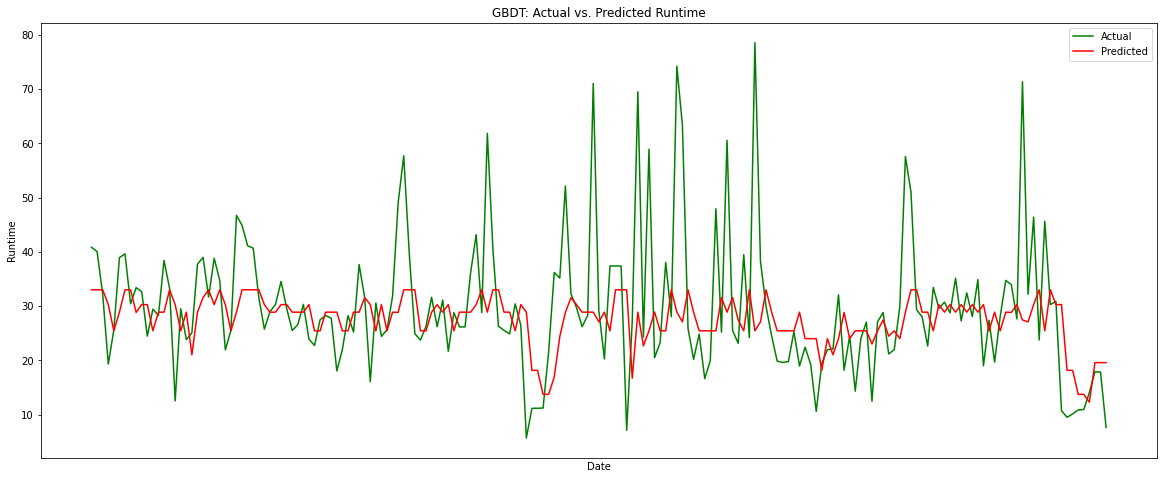

In [ ]:
score = find_rmse(y_test,y_pred)
print("RMSE score:",score)
visualize_results(modelName, y_test, y_pred)
modelScore[modelName] = score

### LSTM Deep Learning Network

In [ ]:
def save_model(model,model_name):
  model_json = model.to_json()
  with open(dirPath+"/gdrive/My Drive/casestudy/model_save/"+model_name+".json", "w") as jsonfile:
    jsonfile.write(model_json)

In [ ]:
def define_model():
  n_features = 1
  modeldl = Sequential()
  modeldl.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(timesteps, n_features)))
  modeldl.add(LSTM(16, activation='relu', return_sequences=True))
  modeldl.add(LSTM(8, activation='relu'))
  modeldl.add(Dense(1))
  modeldl.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return modeldl

In [ ]:
checkpoint = ModelCheckpoint(filepath=dirPath+"/gdrive/My Drive/casestudy/model_save/model.hdf5", monitor= 'val_root_mean_squared_error', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, verbose=1, mode='min')
modelName = 'LSTM'
# Model Definition
modeldl = define_model()

In [ ]:
modeldl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 5, 16)             5184      
                                                                 
 lstm_2 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 22,889
Trainable params: 22,889
Non-trainable params: 0
_________________________________________________________________


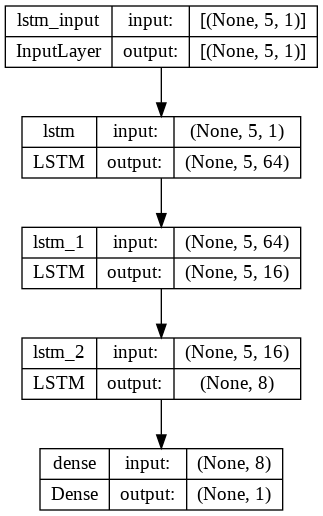

In [ ]:
tf.keras.utils.plot_model(modeldl, to_file=dirPath+'/gdrive/My Drive/casestudy/'+modelName+'.png', show_shapes=True)

In [ ]:
# Save the model definition
save_model(modeldl,modelName)

In [ ]:
h = modeldl.fit(X_train, y_train, epochs=300, verbose=1, callbacks=[earlystop,checkpoint], validation_data=(X_test, y_test)) #
print('Best RMSE: ',min(h.history['val_root_mean_squared_error']))

Epoch 1/300
13/18 [====================>.........] - ETA: 0s - loss: 647.3563 - root_mean_squared_error: 25.4432
Epoch 1: val_root_mean_squared_error improved from inf to 24.76098, saving model to /content/gdrive/My Drive/casestudy/model_save/model.hdf5
18/18 [==============================] - 5s 55ms/step - loss: 621.7425 - root_mean_squared_error: 24.9348 - val_loss: 613.1061 - val_root_mean_squared_error: 24.7610
Epoch 2/300
13/18 [====================>.........] - ETA: 0s - loss: 282.7935 - root_mean_squared_error: 16.8165
Epoch 2: val_root_mean_squared_error improved from 24.76098 to 13.15332, saving model to /content/gdrive/My Drive/casestudy/model_save/model.hdf5
18/18 [==============================] - 0s 14ms/step - loss: 271.3927 - root_mean_squared_error: 16.4740 - val_loss: 173.0098 - val_root_mean_squared_error: 13.1533
Epoch 3/300
17/18 [===========================>..] - ETA: 0s - loss: 187.7570 - root_mean_squared_error: 13.7024
Epoch 3: val_root_mean_squared_error impro

In [ ]:
score = np.round(min(h.history['val_root_mean_squared_error']),3)
print('Best RMSE: ',score)
modelScore[modelName] = score

Best RMSE:  11.792


### ARIMA

We will now, use ARIMA that combines, Auto Regression, Moving averages and differentiation (to remove the effect of trend, that we see in our dataset.) and check its performance.

In [ ]:
modelName = 'ARIMA'

In [ ]:
len(train)

561

In [ ]:
def tune_arima(train, test, plist, qlist, dlist):
  '''
  Find Best ARIMA Hyper Parameters: p,d,q
  '''
  train = list(train)
  best_rmse = math.inf
  best_order = None
  for p in plist:    
    for d in dlist:
      for q in qlist:
        order = (p,d,q)
        model = ARIMA(train, order=order).fit()
        y_pred = model.get_prediction(start=size, end=len(dfseries)-1, dynamic=False)
        rmse = find_rmse(np.array(test), np.array(y_pred.predicted_mean))
        print('ARIMA{} - RMSE: {}'.format(order,rmse))
        if rmse < best_rmse:
          best_rmse = rmse
          best_order = order       
  return best_order, best_rmse

In [ ]:
plist = [timesteps]
dlist = range(0,5)
qlist = range(0,6)
best_order, best_rmse = tune_arima(train, test, plist, qlist, dlist)
print('Best ARIMA{} - RMSE: {}'.format(best_order, best_rmse))
modelScore[modelName] = best_rmse

ARIMA(5, 0, 0) - RMSE: 15.33
ARIMA(5, 0, 1) - RMSE: 12.707
ARIMA(5, 0, 2) - RMSE: 12.695
ARIMA(5, 0, 3) - RMSE: 12.854
ARIMA(5, 0, 4) - RMSE: 12.869
ARIMA(5, 0, 5) - RMSE: 12.893
ARIMA(5, 1, 0) - RMSE: 13.193
ARIMA(5, 1, 1) - RMSE: 13.075
ARIMA(5, 1, 2) - RMSE: 13.076
ARIMA(5, 1, 3) - RMSE: 13.045
ARIMA(5, 1, 4) - RMSE: 13.042
ARIMA(5, 1, 5) - RMSE: 13.041
ARIMA(5, 2, 0) - RMSE: 182.093
ARIMA(5, 2, 1) - RMSE: 14.964
ARIMA(5, 2, 2) - RMSE: 15.232
ARIMA(5, 2, 3) - RMSE: 16.046
ARIMA(5, 2, 4) - RMSE: 15.101
ARIMA(5, 2, 5) - RMSE: 15.743
ARIMA(5, 3, 0) - RMSE: 3391.133
ARIMA(5, 3, 1) - RMSE: 176.634
ARIMA(5, 3, 2) - RMSE: 273.108
ARIMA(5, 3, 3) - RMSE: 171.287
ARIMA(5, 3, 4) - RMSE: 157.157
ARIMA(5, 3, 5) - RMSE: 25.05
ARIMA(5, 4, 0) - RMSE: 261935.878
ARIMA(5, 4, 1) - RMSE: 5764.342
ARIMA(5, 4, 2) - RMSE: 11857.433
ARIMA(5, 4, 3) - RMSE: 906.216
ARIMA(5, 4, 4) - RMSE: 13687.57
ARIMA(5, 4, 5) - RMSE: 644.362
Best ARIMA(5, 0, 2) - RMSE: 12.695


In [ ]:
modelScore

{'Baseline': 15.31,
 'Exponential Moving Averages': 12.834,
 'Linear Regression': 12.602,
 'Decision Tree': 12.569,
 'Random Forest': 12.165,
 'GBDT': 11.938,
 'LSTM': 11.938,
 'ARIMA': 12.695}

In [ ]:
pt = PrettyTable()
pt.field_names = ['Model', 'RMSE Score']
pt.add_row(['Baseline Model', modelScore['Baseline']])
pt.add_row(['Exp. Moving Avg.',  modelScore['Exponential Moving Averages']])
pt.add_row(['Linear Regression',  modelScore['Linear Regression']])
pt.add_row(['Decision Tree',  modelScore['Decision Tree']])
pt.add_row(['Random Forest',  modelScore['Random Forest']])
pt.add_row(['GBDT',  modelScore['GBDT']])
pt.add_row(['LSTM',  modelScore['LSTM']])
pt.add_row(['ARIMA',  modelScore['ARIMA']])
print(pt)

+-------------------+------------+
|       Model       | RMSE Score |
+-------------------+------------+
|   Baseline Model  |   15.31    |
|  Exp. Moving Avg. |   12.834   |
| Linear Regression |   12.602   |
|   Decision Tree   |   12.569   |
|   Random Forest   |   12.165   |
|        GBDT       |   11.938   |
|        LSTM       |   11.938   |
|       ARIMA       |   12.695   |
+-------------------+------------+


### Summary

The LSTM network performed the best in terms of RMSE Score, followed by Random Forest Model - We will use these two models to do an out of sample forecast.

### Univariate Out of Sample Forecasting

**Rolling Forecast with One Step Predictions**

We will use a historical time window with 'n' number of timesteps in the past to arrive at one step forecasting in the future. 'n' is a hyper parameter and we would consider the best value that improves the score.

We will append each of these predicted values to the dataset and refit the model with best params for each time step forecasted. In other words we will perform Rolling forecast with one step predictions.

In [ ]:
def oos_forecast(model, modelName, timesteps, daysteps):
  '''
  Iteratively trains from a historical window of t1 timesteps
  Forecasts into the future window of t2 timesteps - one step at a time
  '''
  timesteps = timesteps
  data = dfseries.values
  daysteps = daysteps
  X_samp = np.array(dfseries.run_time[(0-timesteps):])
  #y_p = 0
  y_pred = []
  # Rolling forecast - Append predicted values to the dataset and refit the model with best params for each time step forecasted.
  for i in range(daysteps):
    X_train, y_train = time_window(data, timesteps)    
    model.fit(X_train.reshape(-1,timesteps), y_train)
    y_p = model.predict(X_samp.reshape(-1,timesteps))
    y_pred.append(y_p[0])
    data = np.append(data,y_p[0])
    for j in range(len(X_samp)-1):
      X_samp[j] =X_samp[j+1] 
    X_samp[-1] = y_p[0]

  # Create a new dataframe with forecasted results.
  dateIndex = pd.date_range(dfseries.index[-1] + timedelta(days=1) , dfseries.index[-1] + timedelta(days=daysteps) , freq='D')
  dfF = pd.DataFrame(columns=['run_time'])
  dfF.loc[dfseries.index[-1]] = dfseries['run_time'][-1]
  dfForecast = pd.DataFrame(data = y_pred, columns = ['run_time'], index= dateIndex)
  dfForecast = pd.concat([dfF, dfForecast], axis=0)
  print('Forecast for next 7 days:\n',dfForecast[1:8])

  # Visualize
  ax = dfseries['run_time'].plot(label='Historical', figsize=(20, 7),color='green')
  dfForecast['run_time'].apply(lambda x : 0 if x<0 else x).plot(ax=ax, label='Forecast', color='red')
  plt.xlabel('Date')
  plt.ylabel('Runtime')
  plt.title(modelName+': Actual Forecasted Runtimes')
  plt.legend()
  plt.show()


#### Forecast using Random Forest

Forecast for next 7 days:
              run_time
2018-02-01  24.708288
2018-02-02  25.175950
2018-02-03  30.447292
2018-02-04  34.131865
2018-02-05  25.623085
2018-02-06  26.256409
2018-02-07  23.266970


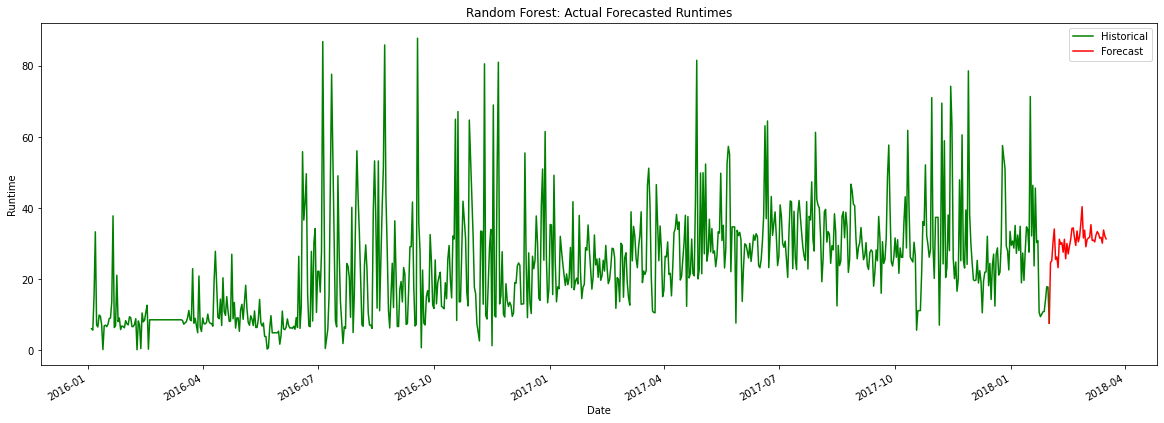

In [ ]:
modelrf = RandomForestRegressor(n_estimators = bestn_estimatorsrf, min_samples_split = bestmin_samples_splitrf ,max_depth  = bestmax_depthrf, min_samples_leaf  =bestmin_samples_leafrf , random_state=101)
oos_forecast(modelrf, 'Random Forest', timesteps = 60, daysteps = 45)

#### Forecast using LSTM network

1/1 [==============================] - 0s 21ms/step
Forecast for next 7 days:
              run_time
2018-02-01   8.988019
2018-02-02  13.973040
2018-02-03  19.976595
2018-02-04  19.373875
2018-02-05  15.023293
2018-02-06  16.756187
2018-02-07  21.042273


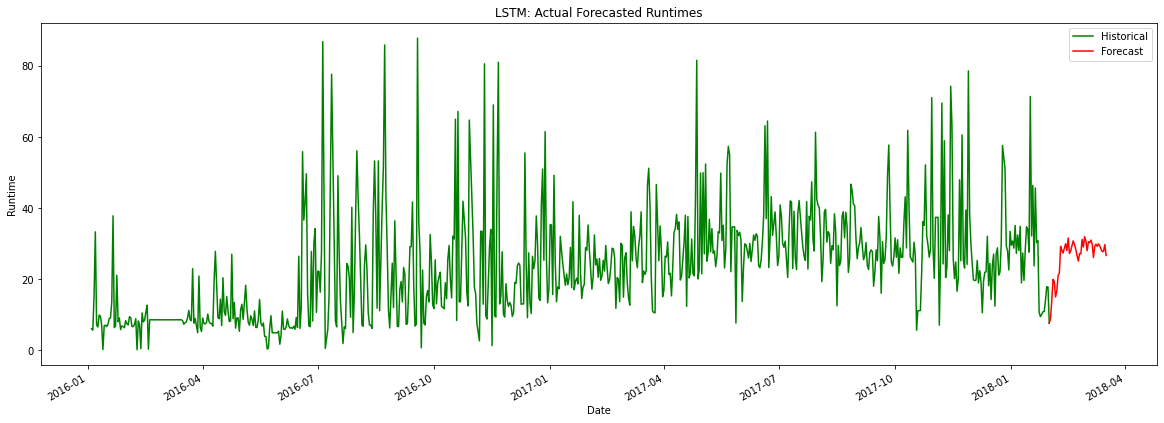

In [ ]:
modeldl = define_model()
oos_forecast(modeldl, 'LSTM', timesteps = 5, daysteps = 45)

Contiued in Part 3...